In [1]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn import linear_model
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from collections import OrderedDict
import scipy.special as sc

In [2]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [53]:
# Sample a normally distorted sine wave
test_samples = 500
a = 0
b = 5 * np.pi
sigma_epsilon = 0.2
X = (b - a) * np.random.random(test_samples) + a
X = X.reshape(-1, 1)
epsilon = sigma_epsilon * np.random.randn(test_samples)
epsilon = epsilon.reshape(-1, 1)
y = np.sin(X) + epsilon
SNR = signaltonoise(y)
f"SNR is {float(SNR): .4f}"

'SNR is  0.1672'

In [22]:
# Normal Ridge Regression
# Objective : Show that the normal Ridge Regression doesn't work with the nonlinear dataset
# #############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)
alphas = alphas.reshape(-1, 1)
print(alphas.shape)
ridgeCoefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    ridgeCoefs.append(ridge.coef_)
ridgeCoefs = np.array(ridgeCoefs)

(10, 10) (10,)
(200, 1)


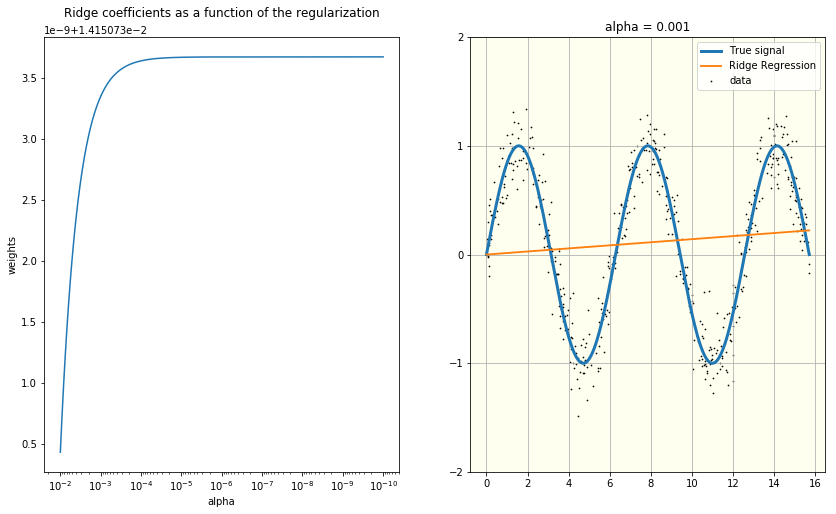

Signal to Noise Ratio : 5.8777


In [75]:
# Display results
fig = plt.figure(figsize = [14, 8])
ax = fig.add_subplot(1,2,1)
ax.plot(alphas, ridgeCoefs[:,0])
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel('alpha')
ax.set_ylabel('weights')
ax.set_title('Ridge coefficients as a function of the regularization', pad=20)

ridge = linear_model.Ridge(alpha=1e-3, fit_intercept=False)
ridge.fit(X, y)
X_plot = np.linspace(0, 5*np.pi, 10000)[:, None]
y_hat_ridge = ridge.predict(X_plot)
ax2 = fig.add_subplot(1,2,2)
ax2.set_facecolor('ivory')
ax2.grid(b=True)
ax2.scatter(X, y, color='black', marker='.', s=2, label='data')
ax2.plot(X_plot, np.sin(X_plot), label='True signal', lw=3)
ax2.plot(X_plot, y_hat_ridge, label='Ridge Regression', lw=np.random.uniform(1,2))
ax2.set_yticks(np.arange(-2,3))
ax2.set_title('alpha = %.3f' %1e-3)
ax2.legend()
plt.savefig('normal_ridge.png', dpi=300, bbox_inches='tight')
plt.show()

# SNR = ||Xbeta||2/||eps||2
beta = ridge.coef_
SNR = (norm(np.matmul(X, beta), 2))/(norm(epsilon, 2))
print(f'Signal to Noise Ratio : %.4f' %SNR)

In [51]:
# Train the classifiers

kernels=['poly', 'polynomial', 'rbf', 'laplacian', 'sigmoid', 'cosine']
X_plot = np.linspace(0, 5*np.pi, 10000)[:, None]

# Radial Basis Function kernel #############################################
kr_rbf = GridSearchCV(KernelRidge(kernel='rbf'),
                  param_grid={"alpha": [0.5, 0.1, 0.05],
                              "gamma": np.logspace(-2, 2, 5)},
                     scoring='explained_variance')
kr_rbf.fit(X, y)
y_hat_rbf = kr_rbf.predict(X_plot)

warnings.filterwarnings("ignore")

# Polynomial kernel ########################################################
kr_polynomial = GridSearchCV(KernelRidge(kernel='polynomial'),
                            param_grid={"alpha": [1e-3, 1e-4],
                                        "gamma": [0.5, 0.1, 0.05],
                                        "degree": [8, 9, 10],
                                       "coef0": [0.5, 1, 2]},
                            scoring='explained_variance')
kr_polynomial.fit(X,y)
y_hat_polynomial = kr_polynomial.predict(X_plot)

# Laplacian kernel #########################################################
kr_laplacian = GridSearchCV(KernelRidge(kernel='laplacian'),
                            param_grid={"alpha": [0.5, 0.1, 0.05],
                                        "gamma": np.logspace(-2, 2, 5)},
                           scoring='explained_variance')
kr_laplacian.fit(X,y)
y_hat_laplacian = kr_laplacian.predict(X_plot)

# Sigmoid kernel ###########################################################
kr_sigmoid = GridSearchCV(KernelRidge(kernel='sigmoid'),
                          param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                                       "gamma": np.logspace(-2, 2, 5),
                                     "coef0": [-1, 0, 1]})
kr_sigmoid.fit(X,y)
y_hat_sigmoid = kr_sigmoid.predict(X_plot)

# Exponential Sine Squared kernel ##########################################
param_grid = {"alpha": [0.5, 1e-1, 0.05],
              "kernel": [ExpSineSquared(l, p)
                         for l in np.logspace(-2, 2, 10)
                         for p in np.logspace(0, 2, 10)]}
kr_ess = GridSearchCV(KernelRidge(), param_grid=param_grid, scoring='explained_variance')
kr_ess.fit(X,y)
y_hat_ess = kr_ess.predict(X_plot)



In [48]:
# Polynomial kernel ########################################################
kr_polynomial = GridSearchCV(KernelRidge(kernel='polynomial'),
                            param_grid={"alpha": [1e-3, 1e-4],
                                        "gamma": [0.5, 0.1, 0.05],
                                        "degree": [8, 9, 10],
                                       "coef0": [1, 5, 10]},
                            scoring='explained_variance')
kr_polynomial.fit(X,y)
y_hat_polynomial = kr_polynomial.predict(X_plot)

In [52]:
# Print best Parameters
classifiers = OrderedDict()
classifiers["RBF"] =  kr_rbf; classifiers['polynomial'] = kr_polynomial
classifiers["laplacian"] = kr_laplacian; classifiers["sigmoid"] = kr_sigmoid;
classifiers['exponential sine squared'] = kr_ess
for kernel,classifier in zip(classifiers.keys(), classifiers.values()):
    print(f'Best chosen parameters for the {kernel} kernel were: {classifier.best_params_}')
    print(f'The explained variance score for the best set of parameters after 5-fold cv is: {classifier.best_score_}')

Best chosen parameters for the RBF kernel were: {'alpha': 0.05, 'gamma': 0.1}
The explained variance score for the best set of parameters after 5-fold cv is: 0.912393246209026
Best chosen parameters for the polynomial kernel were: {'alpha': 0.001, 'coef0': 1, 'degree': 10, 'gamma': 0.05}
The explained variance score for the best set of parameters after 5-fold cv is: 0.9128843096684974
Best chosen parameters for the laplacian kernel were: {'alpha': 0.1, 'gamma': 0.1}
The explained variance score for the best set of parameters after 5-fold cv is: 0.9035723728073288
Best chosen parameters for the sigmoid kernel were: {'alpha': 0.001, 'coef0': -1, 'gamma': 0.1}
The explained variance score for the best set of parameters after 5-fold cv is: 0.826128651606006
Best chosen parameters for the exponential sine squared kernel were: {'alpha': 0.1, 'kernel': ExpSineSquared(length_scale=0.215, periodicity=59.9)}
The explained variance score for the best set of parameters after 5-fold cv is: 0.912327

In [64]:
# Assign parameters to the classifiers

kernels=['poly', 'polynomial', 'rbf', 'laplacian', 'sigmoid', 'cosine']
# X_plot = np.linspace(0, 5*np.pi, 10000)[:, None]

# Radial Basis Function kernel ##############################################
kr_rbf = KernelRidge(kernel='rbf', alpha= 0.05, gamma= 0.1)
kr_rbf.fit(X, y)
y_hat_rbf = kr_rbf.predict(X_plot)

warnings.filterwarnings("ignore")

# Polynomial kernel #########################################################
kr_polynomial = KernelRidge(kernel='polynomial', alpha= 0.001, degree= 6, gamma= 0.1, coef0= 1)
kr_polynomial.fit(X,y)
y_hat_polynomial = kr_polynomial.predict(X_plot)

# Laplacian kernel ##########################################################
kr_laplacian = KernelRidge(kernel='laplacian', alpha= 0.1, gamma= 0.1)
kr_laplacian.fit(X,y)
y_hat_laplacian = kr_laplacian.predict(X_plot)

# Sigmoid kernel ############################################################
kr_sigmoid = KernelRidge(kernel='sigmoid', alpha= 0.0001, gamma= 0.05, coef0= -3)
kr_laplacian.fit(X,y)
y_hat_laplacian = kr_laplacian.predict(X_plot)


# Exponential Sine Squared kernel ###########################################
kr_ess = KernelRidge(kernel=ExpSineSquared(length_scale=0.215, periodicity=59.9), alpha= 0.1)
kr_ess.fit(X,y)
y_hat_ess = kr_ess.predict(X_plot)


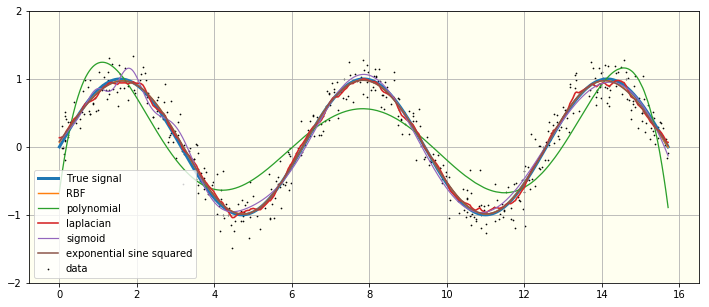

In [65]:
predicted_values = [y_hat_rbf, y_hat_polynomial, y_hat_laplacian, y_hat_sigmoid, y_hat_ess]

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)
ax.set_facecolor('ivory')
ax.grid(b=True)
ax.scatter(X, y, color='black', marker='.', s=2, label='data')
ax.plot(X_plot, np.sin(X_plot), label='True signal', lw=3)
for val, kernel in zip(predicted_values, classifiers.keys()):
    ax.plot(X_plot, val, label=kernel, lw=np.random.uniform(1,2))
ax.set_yticks(np.arange(-2,3))
ax.legend()
plt.savefig('sine.png', dpi=300, bbox_inches='tight')
plt.show()

In [54]:
# Sample a normally distorted sinc wave
test_samples_fresn = 1000
a = 0
b = 8
sigma_epsilon_fresn = 0.3
X_fresn = (b - a) * np.random.random(test_samples_fresn) + a
X_fresn = X_fresn.reshape(-1, 1)
epsilon_fresn = sigma_epsilon_fresn * np.random.randn(test_samples_fresn)
epsilon_fresn = epsilon_fresn.reshape(-1, 1)
y_fresn = sc.fresnel(X_fresn)[0] + epsilon_fresn
SNR = signaltonoise(y_fresn)
f"SNR is {float(SNR): .4f}"

'SNR is  1.4015'

In [32]:
# Train the classifiers
kernels=['poly', 'polynomial', 'rbf', 'laplacian', 'sigmoid', 'cosine']
X_plot_fresn = np.linspace(0, 10, 1001)[:, None]

kr_rbf = GridSearchCV(KernelRidge(kernel='rbf'),
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)},
                  scoring='explained_variance')
kr_rbf.fit(X_fresn, y_fresn)

y_hat_rbf_fresn = kr_rbf.predict(X_plot_fresn)

warnings.filterwarnings("ignore")

kr_polynomial = GridSearchCV(KernelRidge(kernel='polynomial'),
                             param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                                        "gamma": np.logspace(-2, 2, 5),
                                        "degree": np.arange(2,8),
                                        "coef0": np.arange(-2,3)},
                             scoring='explained_variance')
kr_polynomial.fit(X_fresn,y_fresn)
y_hat_polynomial_fresn = kr_polynomial.predict(X_plot_fresn)

kr_laplacian = GridSearchCV(KernelRidge(kernel='laplacian', gamma=0.1),
                            param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                                        "gamma": np.logspace(-2, 2, 5)},
                            scoring='explained_variance')
kr_laplacian.fit(X_fresn,y_fresn)
y_hat_laplacian_fresn = kr_laplacian.predict(X_plot_fresn)

kr_sigmoid = GridSearchCV(KernelRidge(kernel='sigmoid'),
                          param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                                      "gamma": np.logspace(-2, 2, 5),
                                      "coef0": np.arange(-4,5)},
                          scoring='explained_variance')
kr_sigmoid.fit(X_fresn,y_fresn)
y_hat_sigmoid_fresn = kr_sigmoid.predict(X_plot_fresn)

param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],
              "kernel": [ExpSineSquared(l, p)
                         for l in np.logspace(-2, 2, 10)
                         for p in np.logspace(0, 2, 10)]}
kr_ess = GridSearchCV(KernelRidge(), param_grid=param_grid, scoring='explained_variance')
kr_ess.fit(X_fresn,y_fresn)
y_hat_ess_fresn = kr_ess.predict(X_plot_fresn)

In [ ]:
param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],
              "kernel": [ExpSineSquared(l, p)
                         for l in np.logspace(-2, 2, 10)
                         for p in np.logspace(0, 2, 10)]}
kr_ess = GridSearchCV(KernelRidge(), param_grid=param_grid, scoring='explained_variance')
kr_ess.fit(X_fresn,y_fresn)
y_hat_ess_fresn = kr_ess.predict(X_plot_fresn)

In [31]:
# Print best Parameters
classifiers_fresn = OrderedDict()
classifiers_fresn["RBF"] =  kr_rbf; classifiers_fresn['Polynomial'] = kr_polynomial
classifiers_fresn["Laplacian"] = kr_laplacian; classifiers_fresn["Sigmoid"] = kr_sigmoid;
classifiers_fresn['ESS'] = kr_ess
for kernel,classifier_fresn in zip(classifiers_fresn.keys(), classifiers_fresn.values()):
    print(f'Best chosen parameters for the {kernel} kernel were: {classifier_fresn.best_params_}')
    print(f'The explained variance score for the best set of parameters after 5-fold cv is: {classifier_fresn.best_score_}')

AttributeError: 'KernelRidge' object has no attribute 'best_params_'

In [36]:
# Assign parameters to the classifiers

kernels=['poly', 'polynomial', 'rbf', 'laplacian', 'sigmoid', 'cosine']
X_plot_fresn = np.linspace(0, 10, 1001)[:, None]

# Radial Basis Function kernel ##############################################
kr_rbf = KernelRidge(kernel='rbf', alpha= 0.001, gamma= 10)
kr_rbf.fit(X_fresn, y_fresn)
y_hat_rbf_fresn = kr_rbf.predict(X_plot_fresn)

warnings.filterwarnings("ignore")

# Polynomial kernel #########################################################
kr_polynomial = KernelRidge(kernel='polynomial', alpha= 1, degree= 7, gamma= 1, coef0= -1)
kr_polynomial.fit(X_fresn,y_fresn)
y_hat_polynomial_fresn = kr_polynomial.predict(X_plot_fresn)

# Laplacian kernel ##########################################################
kr_laplacian = KernelRidge(kernel='laplacian', alpha= 0.1, gamma= 1)
kr_laplacian.fit(X_fresn,y_fresn)
y_hat_laplacian_fresn = kr_laplacian.predict(X_plot_fresn)

# Sigmoid kernel ############################################################
kr_sigmoid = KernelRidge(kernel='sigmoid', alpha= 0.001, gamma= 1, coef0= -4)
kr_laplacian.fit(X_fresn,y_fresn)
y_hat_sigmoid_fresn = kr_laplacian.predict(X_plot_fresn)

# Exponential Sine Squared kernel ###########################################
kr_ess = KernelRidge(kernel=ExpSineSquared(length_scale=0.0774, periodicity=12.9), alpha= 0.01)
kr_ess.fit(X_fresn,y_fresn)
y_hat_ess_fresn = kr_ess.predict(X_plot_fresn)


In [37]:
# Assign parameters to the classifiers

kernels=['poly', 'polynomial', 'rbf', 'laplacian', 'sigmoid', 'cosine']
X_plot_fresn = np.linspace(0, 10, 1001)[:, None]

# Radial Basis Function kernel ##############################################
kr_rbf_worse1 = KernelRidge(kernel='rbf', alpha= 0.001, gamma= 10)
kr_rbf_worse1.fit(X_fresn, y_fresn)
y_hat_rbf_fresn_worse1 = kr_rbf.predict(X_plot_fresn)

kr_rbf_worse2 = KernelRidge(kernel='rbf', alpha= 0.1, gamma= 0.1)
kr_rbf_worse2.fit(X_fresn, y_fresn)
y_hat_rbf_fresn_worse2 = kr_rbf.predict(X_plot_fresn)


warnings.filterwarnings("ignore")

# Polynomial kernel #########################################################
kr_polynomial_worse1 = KernelRidge(kernel='polynomial', alpha= 0.001, degree= 7, gamma= 1, coef0= -1)
kr_polynomial_worse1.fit(X_fresn,y_fresn)
y_hat_polynomial_fresn_worse1= kr_polynomial.predict(X_plot_fresn)

kr_polynomial_worse2 = KernelRidge(kernel='polynomial', alpha= 1, degree= 7, gamma= 100, coef0= -1)
kr_polynomial_worse2.fit(X_fresn,y_fresn)
y_hat_polynomial_fresn_worse2= kr_polynomial.predict(X_plot_fresn)

kr_polynomial_worse3 = KernelRidge(kernel='polynomial', alpha= 1, degree= 7, gamma= 1, coef0= -10)
kr_polynomial_worse3.fit(X_fresn,y_fresn)
y_hat_polynomial_fresn_worse3= kr_polynomial.predict(X_plot_fresn)

# Laplacian kernel ##########################################################
kr_laplacian_worse1 = KernelRidge(kernel='laplacian', alpha= 0.01, gamma= 1)
kr_laplacian_worse1.fit(X_fresn,y_fresn)
y_hat_laplacian_fresn_worse1 = kr_laplacian.predict(X_plot_fresn)

kr_laplacian_worse2 = KernelRidge(kernel='laplacian', alpha= 0.1, gamma= 0.01)
kr_laplacian_worse2.fit(X_fresn,y_fresn)
y_hat_laplacian_fresn_worse2 = kr_laplacian.predict(X_plot_fresn)

# Sigmoid kernel ############################################################
kr_sigmoid_worse1 = KernelRidge(kernel='sigmoid', alpha= 1, gamma= 1, coef0= -4)
kr_sigmoid_worse1.fit(X_fresn,y_fresn)
y_hat_sigmoid_fresn_worse1 = kr_laplacian.predict(X_plot_fresn)

kr_sigmoid_worse2 = KernelRidge(kernel='sigmoid', alpha= 0.001, gamma= 0.001, coef0= -4)
kr_sigmoid_worse2.fit(X_fresn,y_fresn)
y_hat_sigmoid_fresn_worse2 = kr_laplacian.predict(X_plot_fresn)

kr_sigmoid_worse3 = KernelRidge(kernel='sigmoid', alpha= 0.001, gamma= 1, coef0= 4)
kr_sigmoid_worse3.fit(X_fresn,y_fresn)
y_hat_sigmoid_fresn_worse3 = kr_laplacian.predict(X_plot_fresn)

# Exponential Sine Squared kernel ###########################################
kr_ess_worse1 = KernelRidge(kernel=ExpSineSquared(length_scale=0.774, periodicity=12.9), alpha= 0.01)
kr_ess_worse1.fit(X_fresn,y_fresn)
y_hat_ess_fresn_worse1 = kr_ess.predict(X_plot_fresn)

kr_ess_worse2 = KernelRidge(kernel=ExpSineSquared(length_scale=0.0774, periodicity=12.9), alpha= 1)
kr_ess_worse2.fit(X_fresn,y_fresn)
y_hat_ess_fresn_worse2 = kr_ess.predict(X_plot_fresn)


1

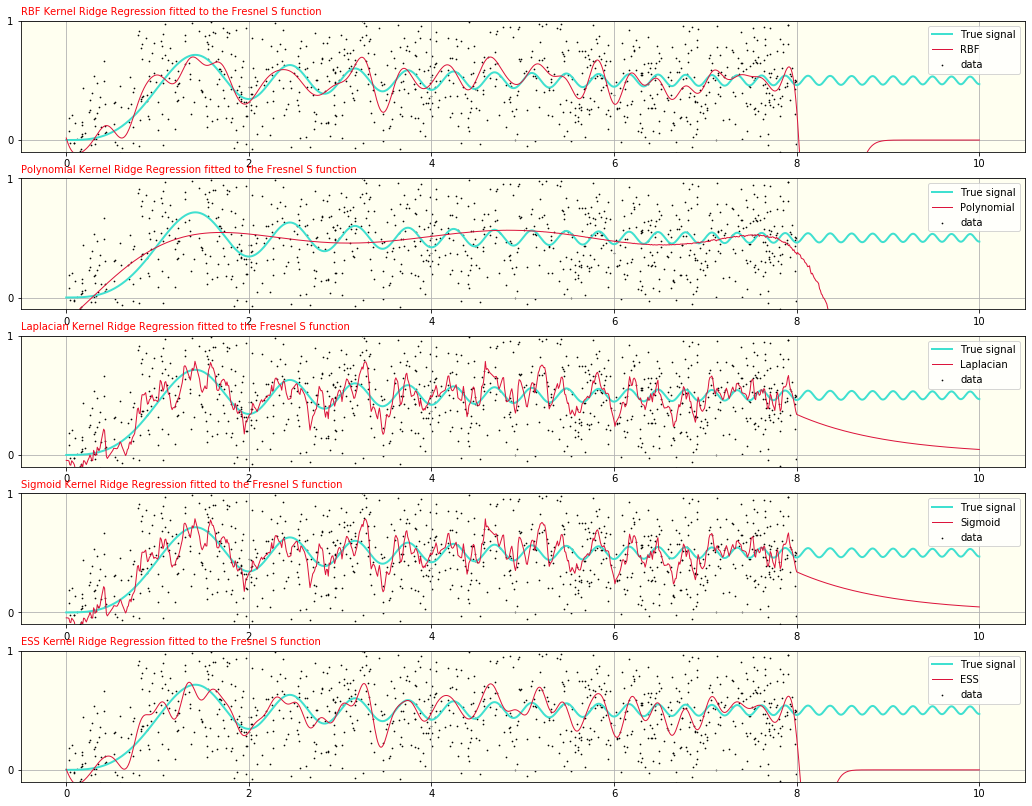

NameError: name 'ridge' is not defined

In [52]:
predicted_values = [y_hat_rbf_fresn, y_hat_polynomial_fresn, y_hat_laplacian_fresn, y_hat_sigmoid_fresn, y_hat_ess_fresn]

fig = plt.figure(figsize=(18,14))
i = 0
for val, kernel in zip(predicted_values, classifiers_fresn.keys()):
    i += 1
    ax = fig.add_subplot(5,1,i)
    ax.set_facecolor('ivory')
    ax.grid(True)
    ax.scatter(X_fresn, y_fresn, color='black', marker='.', s=2, label='data')
    ax.plot(X_plot_fresn, sc.fresnel(X_plot_fresn)[0], color='turquoise', label='True signal', lw=2)
    ax.plot(X_plot_fresn, val, label=kernel, color='crimson', lw=1)
    ax.set_yticks(np.arange(-3,3))
    ax.set_ylim(-0.1,1)
    ax.set_title(f'{kernel} Kernel Ridge Regression fitted to the Fresnel S function', fontsize=10, color = "red", loc="left")
    ax.legend()
plt.savefig('fresnelS_multi_overpredict.png', dpi=300, bbox_inches='tight')
plt.show()

# SNR = ||Xbeta||2/||eps||2
beta = ridge.coef_
SNR = (norm(np.matmul(X, beta), 2))/(norm(epsilon, 2))
print(f'Signal to Noise Ratio : %.4f' %SNR)

In [101]:
i = 0
for j in [1, 2, 3, 4]:
    i += 1
    print(i)

1
2
3
4


In [46]:
v

array([[ 5.81768983e-03],
       [-1.35306424e-02],
       [-3.17153726e-02],
       ...,
       [-5.56520532e-31],
       [-2.85011945e-31],
       [-1.45636380e-31]])